# Modular Addition

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

## Dataset

In [2]:
def one_hot(p):
    """One-hot encode an integer value in R^p."""
    vec = np.zeros(p)
    vec[0] = 1
    return vec

def generate_template(p, magnitude, exponent):
    weight = magnitude * np.power(np.arange(1, p), -exponent)  # Power-law singular values
    template = np.ones(p)  # Base term (DC component)
    for freq in range(1, p):
        template += weight[freq-1] * np.cos(np.arange(p) * freq / p * 2 * np.pi)
    return template / p

def generate_fixed_template(p):
    # Generate template array from Fourier spectrum
    spectrum = np.zeros(p, dtype=complex)
    
    # Set only three frequencies with specific amplitudes
    spectrum[1] = 10 # Positive frequency
    spectrum[-1] = 10  # Negative frequency (conjugate)
    spectrum[3] = 5 # Second frequency
    spectrum[-3] =  5  # Its conjugate
    spectrum[5] = 2.5  # Third frequency 
    spectrum[-5] = 2.5  # Its conjugate
    
    # Generate signal from spectrum
    template = np.fft.ifft(spectrum).real

    return template

def ModularAdditionDataset(p, template):
    # Initialize data arrays
    X = np.zeros((p * p, 2, p))  # Shape: (p^2, 2, p)
    Y = np.zeros((p * p, p))     # Shape: (p^2, p)
    
    # Generate the dataset
    idx = 0
    for a in range(p):
        for b in range(p):
            q = (a + b) % p  # a + b mod p
            X[idx, 0, :] = np.roll(template, a)
            X[idx, 1, :] = np.roll(template, b)
            Y[idx, :] = np.roll(template, q)
            idx += 1
            
    return X, Y

## Architecture

In [3]:
class TwoLayerNet(nn.Module):
    def __init__(self, p, hidden_size, nonlinearity='square', init_scale=1.0, output_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = p
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.init_scale = init_scale
        self.output_scale = output_scale
        
        # Initialize parameters 
        self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2 * p))  # First p elements
        self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2 * p))  # Second p elements
        self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(p)) # Second layer weights
        print(f"Initialized U with shape {self.U.shape}")
        print(f"Initialized V with shape {self.V.shape}")
        print(f"Initialized W with shape {self.W.shape}")

    def forward(self, x):
        print(f"Input x shape: {x.shape}")
        # First layer (linear and combined)
        x1 = x[:, :self.p] @ self.U.T
        print(f"x1 (x @ U.T) shape: {x1.shape}")
        x2 = x[:, self.p:] @ self.V.T
        print(f"x2 (x @ V.T) shape: {x2.shape}")
        x_combined = x1 + x2
        print(f"x_combined (x1 + x2) shape: {x_combined.shape}")

        # Apply nonlinearity activation
        if self.nonlinearity == 'relu':
            x_combined = torch.relu(x_combined)
            print("Applied ReLU nonlinearity")
        elif self.nonlinearity == 'square':
            x_combined = x_combined**2
            print("Applied square nonlinearity")
        elif self.nonlinearity == 'linear':
            x_combined = x_combined
            print("Applied linear (identity) nonlinearity")
        elif self.nonlinearity == 'tanh':
            x_combined = torch.tanh(x_combined)
            print("Applied tanh nonlinearity")
        elif self.nonlinearity == 'gelu':
            gelu = torch.nn.GELU()
            x_combined = gelu(x_combined)
            print("Applied GELU nonlinearity")
        else:
            raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

        # Second layer (linear)
        x_out = x_combined @ self.W
        print(f"x_out (x_combined @ W) shape: {x_out.shape}")

        # Feature learning scaling
        x_out *= self.output_scale
        print(f"x_out after scaling with output_scale={self.output_scale}: shape {x_out.shape}")
        
        return x_out

## Optimization

In [4]:
def test_accuracy(model, dataloader):
    correct = 0
    total = 0
    print("Starting test_accuracy evaluation...")
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            print(f"Batch {i+1}: inputs reshaped")
            outputs = model(inputs)
            print(f"Batch {i+1}: model forward pass done")
            _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
            _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)
            print(f"Batch {i+1}: accuracy updated (correct={correct}, total={total})")
    
    accuracy = 100 * correct / total
    print(f"Final test accuracy: {accuracy:.2f}%")
    return accuracy

def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=10):
    print("Starting training loop...")
    model.train()  # Set the model to training mode
    print("Model set to train mode.")
    loss_history = []  # List to store loss values
    accuracy_history = []
    param_history = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} started.")
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            print(f"  Batch {batch_idx+1}: inputs reshaped")

            optimizer.zero_grad()  # Zero gradients
            print(f"  Batch {batch_idx+1}: optimizer gradients zeroed")
            outputs = model(inputs)  # Forward pass
            print(f"  Batch {batch_idx+1}: model forward pass done")
            loss = criterion(outputs, labels)  # Compute loss
            print(f"  Batch {batch_idx+1}: loss computed ({loss.item():.4f})")
            loss.backward()  # Backpropagation
            print(f"  Batch {batch_idx+1}: backward pass done")
            optimizer.step()  # Update weights
            print(f"  Batch {batch_idx+1}: optimizer step done")

            running_loss += loss.item()
            print(f"  Batch {batch_idx+1}: running_loss updated ({running_loss:.4f})")

        # Append the average loss for the epoch to loss_history
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: avg_loss appended ({avg_loss:.4f})")

        # Append the accuracy
        model.eval()
        print(f"Epoch {epoch+1}: model set to eval mode for accuracy check")
        accuracy = test_accuracy(model, dataloader)
        accuracy_history.append(accuracy)
        print(f"Epoch {epoch+1}: accuracy appended ({accuracy:.2f}%)")
        model.train()
        print(f"Epoch {epoch+1}: model set back to train mode")

        # Save current model parameters
        current_params = {
            "U": model.U.detach().cpu().clone(),
            "V": model.V.detach().cpu().clone(),
            "W": model.W.detach().cpu().clone()
        }
        param_history.append(current_params)
        print(f"Epoch {epoch+1}: model parameters saved")

        # Print verbose information every `verbose_interval` epochs
        if (epoch + 1) % verbose_interval == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    print("Training loop finished.")
    return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [5]:
def style_axes(ax, numyticks=5, numxticks=5, labelsize=24):
    # Y-axis ticks
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=numyticks))
    
    # X-axis ticks
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=numxticks))

    # Scientific notation formatting
    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Customize spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [6]:
def get_power(points):
    p = len(points)
    num_coefficients = (p // 2) + 1
    
    # Perform FFT and calculate power spectrum
    ft = np.fft.fft(points) # Could consider using np.fft.rfft which is designed for real valued input.
    power = np.abs(ft[:num_coefficients])**2 / p
    
    # Double power for frequencies strictly between 0 and Nyquist (Nyquist is not doubled if p is even)
    if p % 2 == 0:  # p is even, Nyquist frequency at index num_coefficients - 1
        power[1:num_coefficients - 1] *= 2
    else:  # p is odd, no Nyquist frequency
        power[1:] *= 2

    # Confirm the power sum approximates the squared norm of points
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    if not np.isclose(total_power, norm_squared, rtol=1e-3):
        print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")

    return np.arange(num_coefficients), power

def interpolate(ax, points, color, continuous, alpha=1.0):
    p = len(points)
    if continuous:
        # Perform Fourier Transform
        ft = np.fft.fft(points)
        
        # Keep only non-negative frequencies (first half + Nyquist if p is even)
        num_coefficients = (p // 2) + 1
        ft = ft[:num_coefficients]  # Truncate to keep non-negative frequencies
        
        # Create a dense set of x-values for smooth interpolation
        xs = np.linspace(0, p, 10 * p)  # 10 times more points than the original for smoothness
        curr_val = np.zeros(xs.shape, dtype=complex)
        
        # Use only non-negative frequencies for interpolation
        for freq in range(num_coefficients):
            theta = np.angle(ft[freq])
            r = np.abs(ft[freq]) / p
            # Double amplitude except for DC (freq = 0) and Nyquist (freq = p / 2, when p is even)
            if freq > 0 and (freq < p / 2 or p % 2 != 0):
                r *= 2
            curr_val += r * np.exp(1j * ((2 * np.pi * freq * xs / p) + theta))

        # Plot the real part (since output is real-valued)
        ax.plot(xs, curr_val.real, color=color, alpha=alpha)
    else:
        ax.plot(np.arange(p), points, color=color, alpha=alpha)   

## Gradient Descent Experiment

In [7]:
seed = 0  # or any integer you like
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Data Generation using the new function
p = 20  # Modulus

# Get base vector
# template = generate_template(p, 2, 1.0)
# template = one_hot(p)
template = generate_fixed_template(p)

# Mean center template
template -= np.mean(template)

# Generate dataset using numpy
X, Y = ModularAdditionDataset(p, template)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * p)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model
hidden_size = 6 * 3
model = TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=1e-2, output_scale=1e0)

# Create loss function
loss = nn.MSELoss()

# Construct optimizer
lr, mom = 0.01, 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Train the model
epochs = 1000001
loss_history, accuracy_history, param_history = train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=epochs//100)

Initialized U with shape torch.Size([18, 20])
Initialized V with shape torch.Size([18, 20])
Initialized W with shape torch.Size([18, 20])
Starting training loop...
Model set to train mode.
Epoch 1 started.
  Batch 1: inputs reshaped
  Batch 1: optimizer gradients zeroed
Input x shape: torch.Size([400, 40])
x1 (x @ U.T) shape: torch.Size([400, 18])
x2 (x @ V.T) shape: torch.Size([400, 18])
x_combined (x1 + x2) shape: torch.Size([400, 18])
Applied square nonlinearity
x_out (x_combined @ W) shape: torch.Size([400, 20])
x_out after scaling with output_scale=1.0: shape torch.Size([400, 20])
  Batch 1: model forward pass done
  Batch 1: loss computed (0.6562)
  Batch 1: backward pass done
  Batch 1: optimizer step done
  Batch 1: running_loss updated (0.6562)
Epoch 1: avg_loss appended (0.6562)
Epoch 1: model set to eval mode for accuracy check
Starting test_accuracy evaluation...
Batch 1: inputs reshaped
Input x shape: torch.Size([400, 40])
x1 (x @ U.T) shape: torch.Size([400, 18])
x2 (x @ 

KeyboardInterrupt: 

## AGF Numerics

In [ ]:
class ModsumSubNetwork(nn.Module):
    
    def __init__(self, d_in, d_out, init_scale):
        super().__init__()
        assert d_in%2 == 0
        self.p = d_in // 2
        self.u = nn.Linear(self.p, 1, bias=False)
        self.v = nn.Linear(self.p, 1, bias=False)
        self.w = nn.Linear(1, d_out, bias=False)
        with torch.no_grad():
            self.w.weight.mul_(init_scale)
            self.u.weight.mul_(init_scale)
            self.v.weight.mul_(init_scale)
        self.active = False
        self.util_acc = 0
        self.c_a = 1/self.get_norm() - 1
        
        self.normalize()
        
    def get_norm(self):
        sqnorm = lambda x: torch.linalg.norm(x.weight)**2
        norm = torch.sqrt(sqnorm(self.w) + sqnorm(self.u) + sqnorm(self.v))
        return norm
    
    def reinitialize(self, u, v, w):
        with torch.no_grad():
            self.u.weight.copy_(u)
            self.v.weight.copy_(v)
            self.w.weight.copy_(w)
        self.c_a = 1/self.get_norm() - 1
    
    def forward(self, x):
        x1 = x[:, :self.p]
        x2 = x[:, self.p:]
        return self.w((self.u(x1) + self.v(x2))**2)
    
    def normalize(self):
        norm = self.get_norm()
        with torch.no_grad():
            self.w.weight.div_(norm)
            self.u.weight.div_(norm)
            self.v.weight.div_(norm)
    
    def utility_step(self, x, residual, learning_rate):
        f_i = self(x)
        util = torch.einsum('nd,nd->n',  f_i, residual).mean()
        self.util_acc += 3 * learning_rate * util.item()
        norm_th = 1/(1 + self.c_a - self.util_acc)
        
        util.backward()
        with torch.no_grad():
            self.w.weight += norm_th * learning_rate * self.w.weight.grad
            self.u.weight += norm_th * learning_rate * self.u.weight.grad
            self.v.weight += norm_th * learning_rate * self.v.weight.grad
            self.w.weight.grad.zero_()
            self.u.weight.grad.zero_()
            self.v.weight.grad.zero_()
            self.normalize()


class ModsumNetwork(nn.Module):
    
    def __init__(self, d_in, d_out, init_scale, width=100):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.width = width
        neurons = [ModsumSubNetwork(d_in, d_out, init_scale) for _ in range(width)]
        self.neurons = nn.ModuleList(neurons)
        self.set_mode("utilmax")
    
    def load_init(self, U, V, W):
        for i, n in enumerate(self.neurons):
            u, v, w = U[i], V[i], W[i][:, None]
            n.reinitialize(u, v, w)

    def dormant(self):
        return [neuron for neuron in self.neurons if not neuron.active]
    
    def active(self):
        return [neuron for neuron in self.neurons if neuron.active]

            
    def set_mode(self, mode):
        if mode not in ["utilmax", "costmin"]:
            raise ValueError("mode must be utilmax or costmin")
        self.mode = mode
        for neuron in self.neurons:
            grad_on = (mode=="utilmax") ^ neuron.active
            for param in neuron.parameters():
                param.requires_grad = grad_on
    
    def forward(self, x):
        if not np.any([n.active for n in self.neurons]):
            return torch.zeros(x.shape[0], self.d_out)
        else:
            outputs = torch.stack([neuron(x) for neuron in self.neurons if neuron.active], dim=0)
            return torch.sum(outputs, dim=0)


def train_agf(X_train, Y_train, init_sz=1e-3, agf_steps=5, from_init=None, 
              utilmax_lr=1, costmin_lr=1, costmin_maxiter=1e4, loss_thresh=1e-4):
    
    # Initialize
    d_in, d_out = X_train.shape[-1], Y_train.shape[-1]
    if from_init:
        U, V, W = from_init["U"], from_init["V"], from_init["W"]
        assert d_in == U.shape[1]*2
        assert d_out == W.shape[1]
        width = U.shape[0]
        net = ModsumNetwork(d_in, d_out, init_sz, width=width)#.cuda()
        net.load_init(U, V, W)
    else:
        net = ModsumNetwork(d_in, d_out, init_sz, width=agf_steps)#.cuda()
    X_train.requires_grad = False
    
    def update_results(results, t):
        results["t"].append(t)
        residual = (Y_train - net(X_train))
        residual = residual.detach()
        results["residuals"].append(residual)
        loss = (residual**2).mean().item()
        results["losses"].append(loss)
        results["models"].append(net.state_dict())
        results["pred"].append(net(X_train).detach().cpu().clone())
        
    results = {
        "t": [],
        "residuals": [],
        "losses": [],
        "models": [],
        "pred": [],
    }

    t = 0
    update_results(results, t)
    for _ in tqdm(range(agf_steps)):
        
        # Utility Maximization
        residual = (1/d_out) * 2*(Y_train - net(X_train))
        residual = residual.detach()
        iters = 0
        mode = "utilmax"
        while mode == "utilmax":
            for n in net.neurons:
                if n.active:
                    continue
                n.utility_step(X_train, residual, utilmax_lr)
                if n.util_acc > n.c_a:
                    n.active = True
                    mode = "costmin"
                    # break
            iters += 1
        net.set_mode(mode)
        t += iters

        # Cost Minimization
        optimizer = torch.optim.SGD(net.parameters(), lr=costmin_lr, momentum=0.9)
        for i in range(int(costmin_maxiter)):
            optimizer.zero_grad(set_to_none=False)
            residual = Y_train - net(X_train)
            loss = (residual ** 2).mean()
            loss.backward()
            optimizer.step()
        net.set_mode("utilmax")

        
        print(f"loss: {loss.item():.5f}")
        update_results(results, t)

        # Check for Termination
        if not net.dormant() or loss.item() < loss_thresh:
            break
    
    return results

In [ ]:
costmin_lr = 0.01
utilmax_lr = 0.1
results = train_agf(X_tensor, Y_tensor, init_sz=model.init_scale, agf_steps=50, from_init=param_history[0],
                    utilmax_lr=utilmax_lr, costmin_lr=costmin_lr,
                    costmin_maxiter=1e4, loss_thresh=1e-4)

  2%|█▉                                                                                             | 1/50 [00:07<06:21,  7.79s/it]

loss: 0.59959


  4%|███▊                                                                                           | 2/50 [00:11<04:12,  5.27s/it]

loss: 0.40936


  6%|█████▋                                                                                         | 3/50 [00:15<03:39,  4.68s/it]

loss: 0.28390


  8%|███████▌                                                                                       | 4/50 [00:22<04:18,  5.62s/it]

loss: 0.22541


 10%|█████████▌                                                                                     | 5/50 [00:28<04:25,  5.89s/it]

loss: 0.15626


 12%|███████████▍                                                                                   | 6/50 [01:00<10:52, 14.82s/it]

loss: 0.13111


 14%|█████████████▎                                                                                 | 7/50 [01:08<08:58, 12.52s/it]

loss: 0.09157


 16%|███████████████▏                                                                               | 8/50 [01:16<07:38, 10.91s/it]

loss: 0.05218


 18%|█████████████████                                                                              | 9/50 [01:26<07:19, 10.73s/it]

loss: 0.03127


 20%|██████████████████▊                                                                           | 10/50 [02:48<21:48, 32.70s/it]

loss: 0.03125


 22%|████████████████████▋                                                                         | 11/50 [03:38<24:44, 38.06s/it]

loss: 0.02345


 24%|██████████████████████▌                                                                       | 12/50 [04:17<24:16, 38.33s/it]

loss: 0.00857


 24%|██████████████████████▌                                                                       | 12/50 [04:30<14:16, 22.53s/it]

loss: 0.00007


## Plot Loss

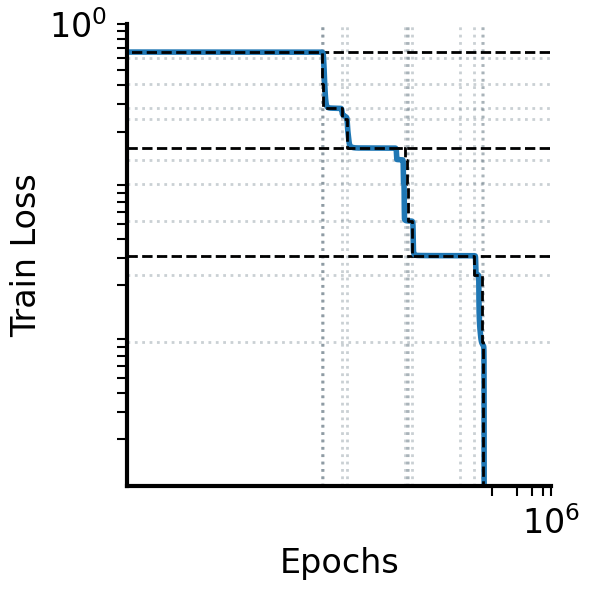

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)

for lossval in results["losses"]:
    ax.axhline(lossval, alpha=0.3, ls=":", color="xkcd:slate", zorder=-4, lw=2)

f = utilmax_lr / (lr/(1-mom))
for t in results["t"]:
    ax.axvline(f*t, alpha=0.3, ls=":", color="xkcd:slate", zorder=-4, lw=2)

times = results["t"] + [epochs]
AGF_losses = results["losses"] + [results["losses"][-1]]
ax.step(f*np.array(times), AGF_losses, where="post", lw=2, ls='dashed', color="k")

# === Compute power spectrum of template ===
freq, power = get_power(template)
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef * alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e1, 1e6)
ax.set_ylim(1e-3, 1e0)
ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

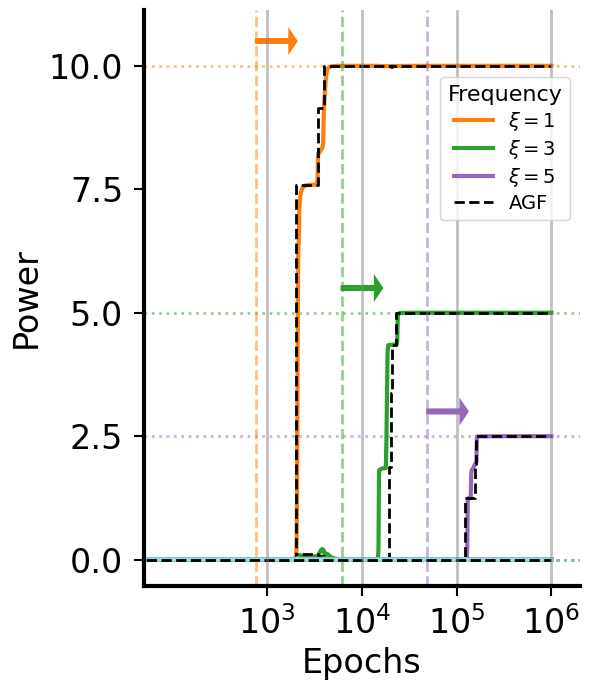

In [ ]:
# === SETTINGS ===
p = Y_tensor.shape[1]
num_freqs = p // 2 + 1

# Compute template power spectrum
template_ft = np.fft.rfft(template)
template_power = np.abs(template_ft)[:num_freqs]

# === Compute power spectrum of template ===
freq, power = get_power(template)
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

# === Theory lines ===
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
theta0 = np.sqrt(2) * model.init_scale
uMax = [np.sqrt(2 * p / 27) * (p * power[k] / 2)**(3/2) / p**2 for k in range(len(power))]
tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
step_size = 2 * coef * lr / (1 - mom)


# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

# Compute output power over time (GD)
num_points = 1000
steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
powers_over_time = []

for step in steps:
    model.load_state_dict(param_history[step])
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
        avg_power = np.mean(np.abs(ft), axis=0)
        powers_over_time.append(avg_power)

powers_over_time = np.array(powers_over_time)  # shape: (steps, freqs)


# Compute output power over time (AGF)
f = utilmax_lr / (lr/(1-mom))
AGF_steps = results["t"]
powers_over_time_AGF = []
for i, step in enumerate(AGF_steps):
    outputs = results["pred"][i]
    ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
    avg_power = np.mean(np.abs(ft), axis=0)
    powers_over_time_AGF.append(avg_power)
powers_over_time_AGF = np.array(powers_over_time_AGF)  # shape: (steps, freqs)
AGF_steps = [f * t for t in AGF_steps]

AGF_steps.append(epochs)
powers_over_time_AGF = np.vstack([
    powers_over_time_AGF,
    powers_over_time_AGF[-1, :]
])

# === PLOTTING ===
fig, ax = plt.subplots(figsize=(6, 7))

for k in range(num_freqs):
    color = colors[k]
    label = fr"$\xi = {k}$" if k in [1, 3, 5] else None
    ax.plot(steps, powers_over_time[:, k], color=color, lw=3, label=label)
    label_agf = 'AGF' if k == 10 else None
    ax.step(AGF_steps, powers_over_time_AGF[:, k], color='k', lw=2, ls='dashed', where="post", label=label_agf)
    ax.axhline(template_power[k], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

for k, tau in enumerate(tau_values):
    color = colors[freq[k]]
    ax.axvline(x=tau / step_size, color=color, linestyle='dashed', linewidth=2, alpha=0.5)

    # Add arrow at intersection
    x = tau / step_size
    y = template_power[freq[k]]
    #draw an arrow from the lower bound to the right
    #use default color cycle
    ax.arrow(1.04 * x, y + 0.5, 1.5 * x, 0, 
             head_width=0.2, head_length=x*0.2, length_includes_head=True,
             fc=color, ec=color, lw=4)

# # Add vertical lines if needed
# for step in time_steps:
#     ax.axvline(x=step, color='gray', alpha=0.5, linestyle='solid', linewidth=2)

# Labeling and formatting
ax.set_xscale('log')
ax.set_xlim(5e1, 2e6)
ax.set_xticks([1000, 10000, 100000, epochs-1])
ax.set_ylabel("Power", fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

style_axes(ax)
ax.set_xticks([1000, 10000, 100000, epochs-1])
ax.grid(False)
plt.tight_layout()
plt.savefig("fourier_power_only.pdf", bbox_inches="tight")
plt.show()

## Plot outputs

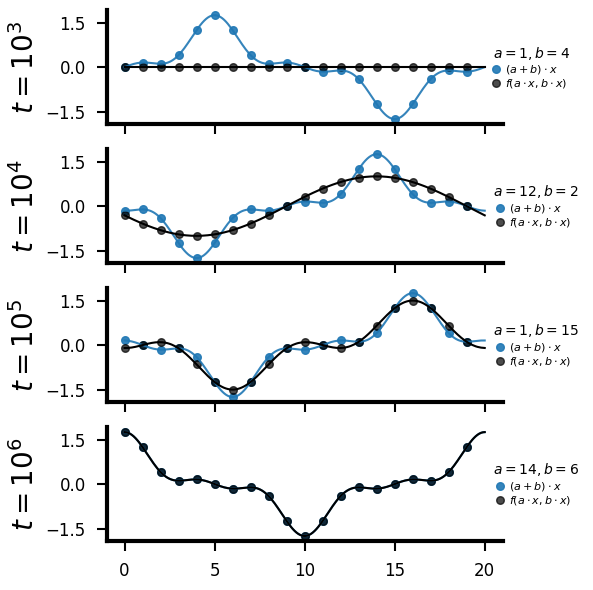

In [ ]:
import matplotlib.pyplot as plt

# Choose time steps to visualize
steps_to_show = [1000, 10000, 100000, epochs-1]
num_samples = 1  # how many examples to plot per row
p = Y_tensor.shape[1]
x = np.arange(p)

fig, axes = plt.subplots(len(steps_to_show), 1, figsize=(6, 6), sharex=True)

for row, step in enumerate(steps_to_show):
    # Load weights at this step
    model.load_state_dict(param_history[step])
    model.eval()

    indices = np.random.choice(len(Y_tensor), size=num_samples, replace=False)
    with torch.no_grad():
        preds = model(X_tensor[indices]).detach().cpu().numpy()
        truths = Y_tensor[indices].detach().cpu().numpy()

    ax = axes[row]
    for i, idx in enumerate(indices):
        a = idx // p
        b = idx % p
        label_true = r"$(a + b) \cdot x$"
        label_pred = r"$f(a \cdot x, b \cdot x)$"

        # Plot ground truth
        interpolate(ax, truths[i], color=f"C{i}", alpha=0.9, continuous=True)
        ax.scatter(x, truths[i], color=f"C{i}", s=30, alpha=0.9, label=label_true)

        # Plot prediction
        interpolate(ax, preds[i], color='k', alpha=1.0, continuous=True)
        ax.scatter(x, preds[i], color='k', s=30, alpha=0.7, label=label_pred)

    style_axes(ax, numyticks=3, labelsize=12)
    ax.grid(False)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(step))}}}$", fontsize=20)

    # Only bottom row gets x-ticks
    if row < len(steps_to_show) - 1:
        ax.tick_params(labelbottom=False)

    # ax.legend(loc='best', fontsize=12, title=fr"$a = {a}, b = {b}$", handlelength=0, labelspacing=0.1, title_fontsize=14, frameon=False)
    ax.legend(
        loc='center left',
        bbox_to_anchor=(0.95, 0.5),  # X slightly beyond the right edge, Y centered
        fontsize=8,
        title=fr"$a = {a}, b = {b}$",
        title_fontsize=10,
        handlelength=0,
        labelspacing=0.1,
        frameon=False
    )

# axes[-1].set_xlabel("Output Index", fontsize=20)
plt.tight_layout()
plt.savefig("predictions.pdf", bbox_inches='tight')

## Plot Weights

/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/var/folders/4g/shvz3x5d6rx38cxrtg_wmtw80000gn/T/ipykernel_46920/4254458089.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("W-weights.pdf", bbox_inches='tight')
/Users/danielkunin/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


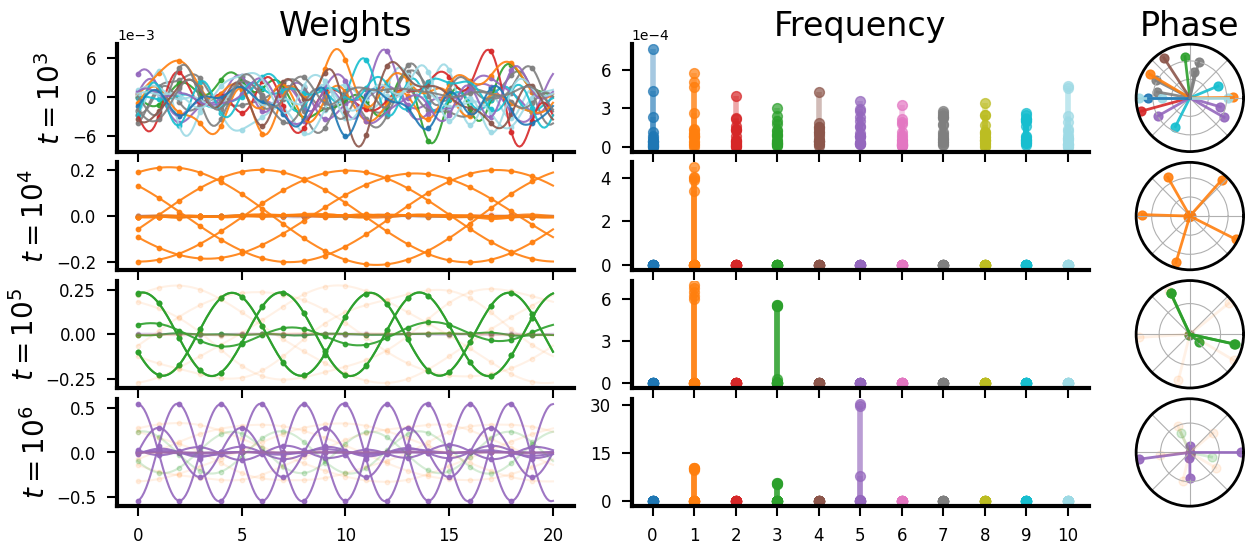

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

# Steps and corresponding highlighted frequencies

steps = [1000, 10000, 100000, epochs-1]
highlight_freqs_list = [[], [1], [3], [5]]

num_rows, num_cols = len(steps), 3

# Use gridspec to control layout
fig = plt.figure(figsize=(24, 6), constrained_layout=True)
gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1.1, 1.1, 2.0], wspace=0.1, hspace=0.1)
axes = np.empty((num_rows, num_cols), dtype=object)

# Create axes
for row in range(num_rows):
    for col in range(num_cols):
        if col == 2:
            ax = fig.add_subplot(gs[row, col], projection='polar')
        else:
            ax = fig.add_subplot(gs[row, col])  # ⬅ no sharex anymore
        axes[row, col] = ax

num_freqs = None
for row, index in enumerate(steps):
    highlight_freqs = highlight_freqs_list[row]
    params = param_history[index]
    W = params['W'].numpy()
    h, p = W.shape

    if num_freqs is None:
        num_freqs = p // 2 + 1
        cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
        colors = [cmap(i) for i in range(num_freqs)]
        manual_colors = {
            0: 'tab:blue',
            1: 'tab:orange',
            2: 'tab:red',
            3: 'tab:green',
            4: 'tab:brown',
            5: 'tab:purple',
        }
        freq_colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]


    # === Column 1: Weights ===
    ax = axes[row, 0]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        x = np.linspace(0, p - 1, 500)
        interpolate(ax, w, color=color, continuous=True, alpha=alpha)
        ax.scatter(np.arange(p), w, color=color, s=10, alpha=alpha)
    if row == 0: ax.set_title("Weights", fontsize=24)
    ax.set_ylabel(fr"$t = 10^{{{int(np.log10(index))}}}$", fontsize=20)
    style_axes(ax, numyticks=3, numxticks=5, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 2: Frequency Spectrum ===
    ax = axes[row, 1]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        for k in range(len(power)):
            color = freq_colors[k]
            ax.vlines(k, 0, power[k], linewidth=4, color=color, alpha=0.4)
            ax.scatter(k, power[k], color=color, s=50, alpha=0.7)
    # ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.4)
    ax.set_xlim(-0.5, len(power) - 0.5)
    ax.set_xticks(np.arange(len(power)))
    if row == 0: ax.set_title("Frequency", fontsize=24)
    style_axes(ax, numyticks=3, numxticks=11, labelsize=12)
    ax.grid(False)
    if row < num_rows - 1:
        ax.tick_params(labelbottom=False)

    # === Column 3: Phase Polar Plot ===
    ax = axes[row, 2]
    for i in range(h):
        w = W[i, :]
        ft = np.fft.rfft(w)
        power = np.abs(ft)**2
        dom_idx = np.argmax(power)
        phase = np.angle(ft[dom_idx])
        norm = np.linalg.norm(w)
        color = freq_colors[dom_idx]
        alpha = 0.9 if not highlight_freqs or dom_idx in highlight_freqs else 0.1
        ax.plot([phase, phase], [0, norm], color=color, linewidth=2, alpha=alpha)
        ax.scatter(phase, norm, color=color, s=40, alpha=alpha)
        angles = np.arange(0, 360, 45)
        # ax.set_thetagrids(angles, [f"{a}°" if a in [45,135,225,315] else "" for a in angles])
        ax.set_thetagrids(angles, ["" for a in angles])
        ax.set_yticklabels([])
        ax.spines['polar'].set_linewidth(2)
    if row == 0: ax.set_title("Phase", fontsize=24)

# Shift polar plots left to reduce whitespace
for row in range(num_rows):
    ax = axes[row, 2]
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.155, pos.y0, pos.width, pos.height])

plt.savefig("W-weights.pdf", bbox_inches='tight')